# Libraries

In [1]:
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold


import optuna
import xgboost as xgb

import tensorflow as tf

C:\Users\firma\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset

In [3]:
df_train = pd.read_csv('C:/Users/firma/Documents/Python/ML + BE/CLASSIFICATION/Kidney Stone Prediction/ML/Data/train.csv')
df_test = pd.read_csv('C:/Users/firma/Documents/Python/ML + BE/CLASSIFICATION/Kidney Stone Prediction/ML/Data/test.csv')
df_sample = pd.read_csv('C:/Users/firma/Documents/Python/ML + BE/CLASSIFICATION/Kidney Stone Prediction/ML/Data/sample_submission.csv')

# Data Information

## Train

In [4]:
df_train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [6]:
obj = [col for col in df_train.columns if df_train[col].nunique() <= 10]
for col in obj:
   print(f"Column: {col}")
   print(f"Number of Unique Values (nunique): {df_train[col].nunique()}")
   print(f"Unique Values: {df_train[col].unique()}")
   print("Value Counts:")
   print(df_train[col].value_counts())
   print("-" * 50)

Column: target
Number of Unique Values (nunique): 2
Unique Values: [0 1]
Value Counts:
target
0    230
1    184
Name: count, dtype: int64
--------------------------------------------------


## Test

In [7]:
df_test.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


# Exploratory Data Analysis

## Numerical Plot

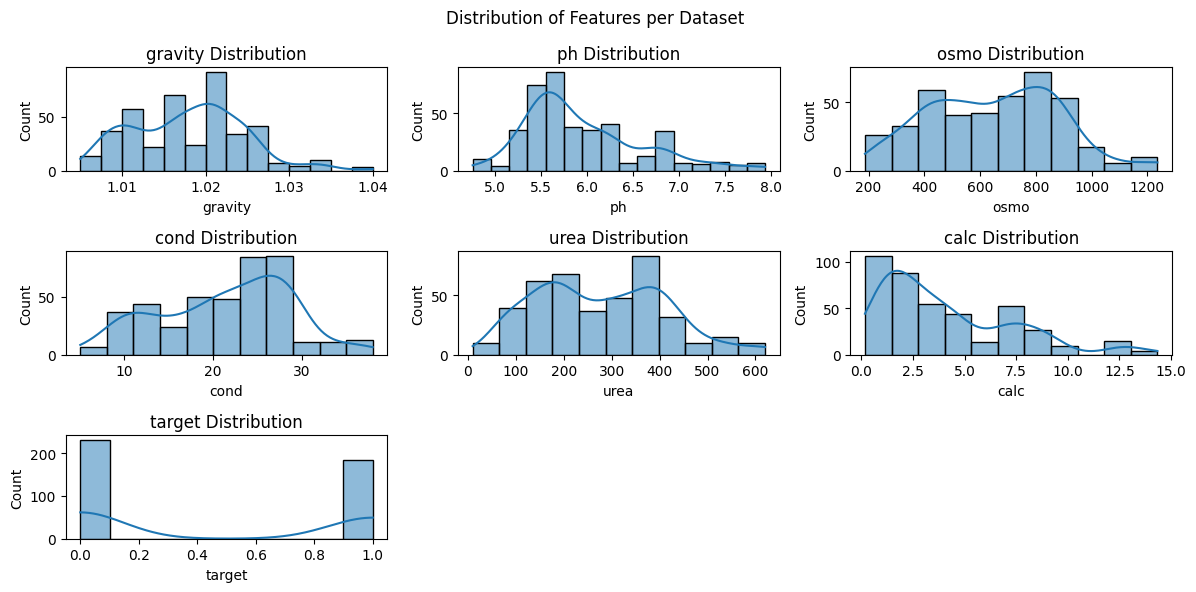

In [8]:
num_cols = [col for col in df_train.columns if df_train[col].dtype in ['float64', 'int64'] and col not in ['id']]
fig, axes = plt.subplots(3,3, figsize = (12,6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  ax = sns.histplot(data=df_train, x=col, ax=axes[i], kde=True)
  ax.set_title(f'{col} Distribution')
  ax.set_xlabel(f'{col}')

for j in range(i+1, len(axes)):
  fig.delaxes(axes[j])

fig.suptitle('Distribution of Features per Dataset')
plt.tight_layout()
plt.show()

## Categorical

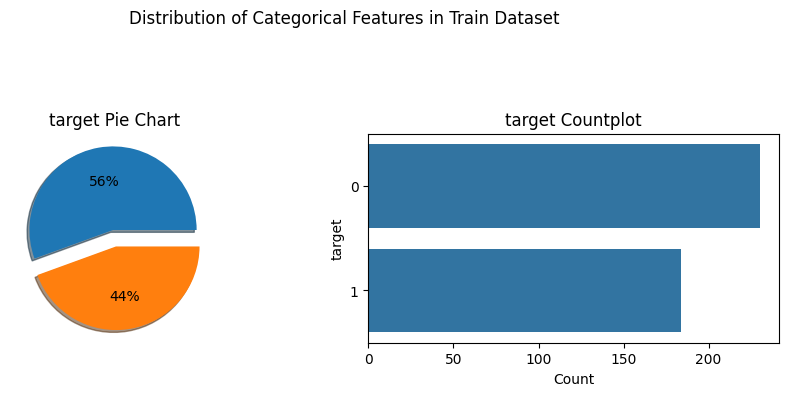

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

ax = axes[0]
ax.pie(
    df_train['target'].value_counts(),
    shadow=True,
    explode=[0.1 for _ in range(df_train['target'].nunique())],
    autopct='%1.f%%'
)
ax.set_aspect('equal')
ax.set_title('target Pie Chart')

ax1 = axes[1]
sns.countplot(
    y='target',
    ax=ax1,
    order=df_train['target'].value_counts().index,
    data=df_train
)
ax1.set_xlabel('Count')
ax1.set_ylabel('target')
ax1.set_title('target Countplot')

fig.suptitle('Distribution of Categorical Features in Train Dataset\n\n\n')

plt.tight_layout()
plt.show()

## Heatmap

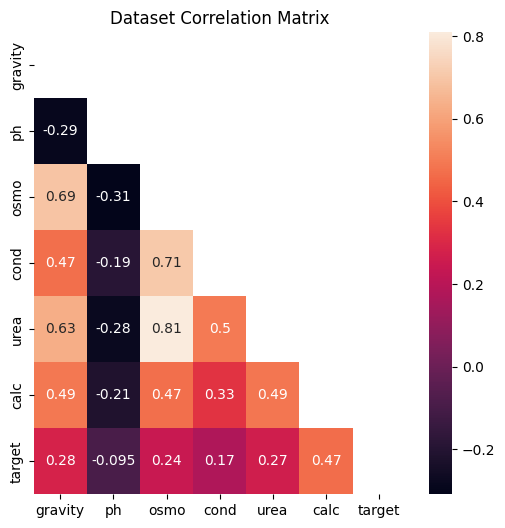

In [10]:
columns = [col for col in df_train.columns if df_train[col].dtype in ['int64', 'float64'] and col not in ['id']]

corr = df_train[columns].corr()
plt.figure(figsize=(6, 6))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.title('Dataset Correlation Matrix')
plt.show()

# Data Preprocessing

In [11]:
def data_preprocessing(df):
    df['urine_volume'] = (1000 * df['gravity'] * df['osmo']) / (18 * 1.001)
    df['specific_gravity_calcium_ratio'] = df['gravity'] / df['calc']
    df['calcium_conductivity_ratio'] = df['calc'] / df['cond']
    df['calcium_pH_interaction'] = df['calc'] * df['ph']
    df['urea_pH_interaction'] = df['urea'] * df['ph']
    df['osmolarity_calcium_interaction'] = df['osmo'] * df['calc']
    
    return df

In [12]:
df_train = data_preprocessing(df_train)
df_test = data_preprocessing(df_test)

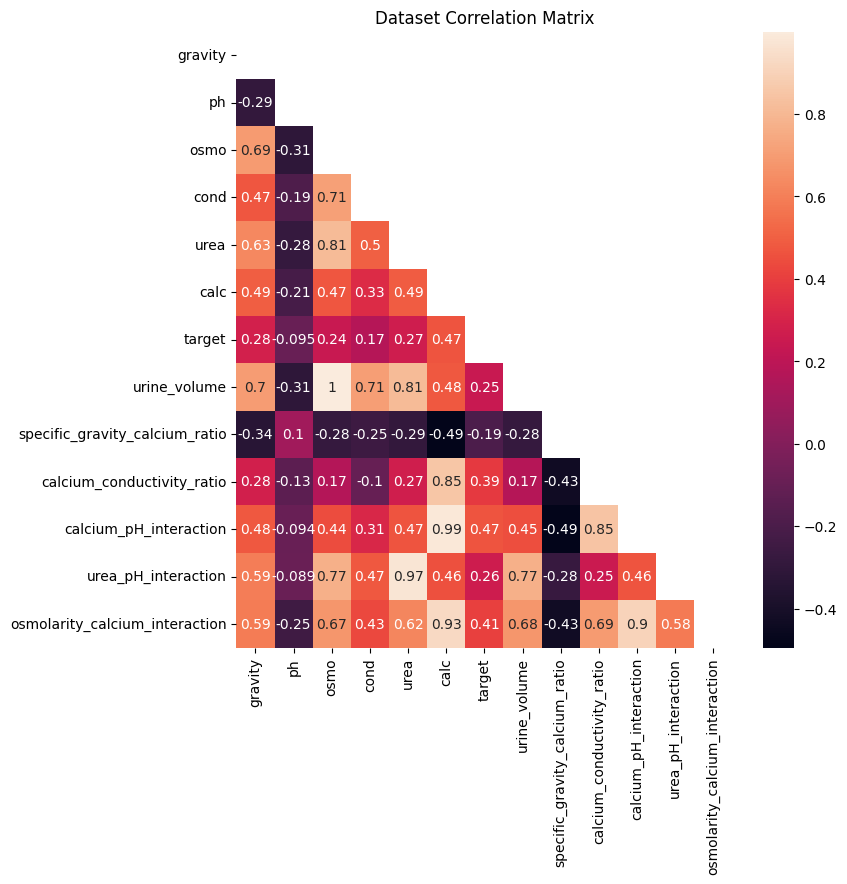

In [13]:
columns = [col for col in df_train.columns if df_train[col].dtype in ['int64', 'float64'] and col not in ['id']]

corr = df_train[columns].corr()
plt.figure(figsize=(8, 8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.title('Dataset Correlation Matrix')
plt.show()

In [14]:
df_train.head()

,id,gravity,ph,osmo,cond,urea,calc,target,urine_volume,specific_gravity_calcium_ratio,calcium_conductivity_ratio,calcium_pH_interaction,urea_pH_interaction,osmolarity_calcium_interaction
0,0,1.013,6.19,443,14.8,124,1.45,0,24906.149406,0.698621,0.097973,8.9755,767.56,642.35
1,1,1.025,5.40,703,23.6,394,4.18,0,39991.952492,0.245215,0.177119,22.5720,2127.60,2938.54
2,2,1.009,6.13,371,24.5,159,9.04,0,20775.835276,0.111615,0.368980,55.4152,974.67,3353.84
3,3,1.021,4.91,442,20.8,398,6.63,1,25046.176046,0.153997,0.318750,32.5533,1954.18,2930.46
4,4,1.021,5.53,874,17.8,385,2.21,1,49525.696526,0.461991,0.124157,12.2213,2129.05,1931.54


# Data Modeling

## Train Test Split

In [15]:
features = [col for col in df_train.columns if col not in ['id','target']]
target = 'target'

In [17]:
X = df_train[features]
y = df_train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Cross validation

In [18]:
def crossval(model, X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)

        print(f"Fold {fold + 1}: Accuracy: {score:.4f}")
        scores.append(score)

    avg_score = np.mean(scores)
    print(f"Average Accuracy: {avg_score:.4f}")
    return scores

## Hyperparameter

In [19]:
def objective_xgb(trial):
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'eval_metric': 'error',
        'verbosity': 0,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**xgb_params)
    scores = crossval(model, X, y)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=10)

best_learning_rate = study.best_params['learning_rate']

[I 2025-06-23 22:53:10,234] A new study created in memory with name: no-name-0f2b9124-8e87-4fbd-889a-074a9e83a62e


Fold 1: Accuracy: 0.6905
Fold 2: Accuracy: 0.6429
Fold 3: Accuracy: 0.6429
Fold 4: Accuracy: 0.7619
Fold 5: Accuracy: 0.6829
Fold 6: Accuracy: 0.7561
Fold 7: Accuracy: 0.8049


[I 2025-06-23 22:53:11,162] Trial 0 finished with value: 0.7006387921022067 and parameters: {'learning_rate': 0.9174139740856885}. Best is trial 0 with value: 0.7006387921022067.


Fold 8: Accuracy: 0.6341
Fold 9: Accuracy: 0.7073
Fold 10: Accuracy: 0.6829
Average Accuracy: 0.7006
Fold 1: Accuracy: 0.7143
Fold 2: Accuracy: 0.6905
Fold 3: Accuracy: 0.6429
Fold 4: Accuracy: 0.7619
Fold 5: Accuracy: 0.7561
Fold 6: Accuracy: 0.7317
Fold 7: Accuracy: 0.8537
Fold 8: Accuracy: 0.7073
Fold 9: Accuracy: 0.7073


[I 2025-06-23 22:53:11,962] Trial 1 finished with value: 0.727293844367015 and parameters: {'learning_rate': 0.1774817395091847}. Best is trial 1 with value: 0.727293844367015.


Fold 10: Accuracy: 0.7073
Average Accuracy: 0.7273
Fold 1: Accuracy: 0.6667
Fold 2: Accuracy: 0.6905
Fold 3: Accuracy: 0.6667
Fold 4: Accuracy: 0.6905
Fold 5: Accuracy: 0.7073
Fold 6: Accuracy: 0.7561
Fold 7: Accuracy: 0.7561
Fold 8: Accuracy: 0.6341
Fold 9: Accuracy: 0.7073


[I 2025-06-23 22:53:12,676] Trial 2 finished with value: 0.6933797909407665 and parameters: {'learning_rate': 0.45177673454230755}. Best is trial 1 with value: 0.727293844367015.


Fold 10: Accuracy: 0.6585
Average Accuracy: 0.6934
Fold 1: Accuracy: 0.6905
Fold 2: Accuracy: 0.6667
Fold 3: Accuracy: 0.6667
Fold 4: Accuracy: 0.7143
Fold 5: Accuracy: 0.6829
Fold 6: Accuracy: 0.7317
Fold 7: Accuracy: 0.8537
Fold 8: Accuracy: 0.6341


[I 2025-06-23 22:53:13,442] Trial 3 finished with value: 0.7030778164924506 and parameters: {'learning_rate': 0.4310591959751333}. Best is trial 1 with value: 0.727293844367015.


Fold 9: Accuracy: 0.7073
Fold 10: Accuracy: 0.6829
Average Accuracy: 0.7031
Fold 1: Accuracy: 0.6429
Fold 2: Accuracy: 0.6905
Fold 3: Accuracy: 0.5952
Fold 4: Accuracy: 0.7143
Fold 5: Accuracy: 0.7073
Fold 6: Accuracy: 0.7317
Fold 7: Accuracy: 0.7805
Fold 8: Accuracy: 0.6585
Fold 9: Accuracy: 0.6829
Fold 10: Accuracy: 0.7317
Average Accuracy: 0.6936


[I 2025-06-23 22:53:14,079] Trial 4 finished with value: 0.6935540069686411 and parameters: {'learning_rate': 0.8312234432833432}. Best is trial 1 with value: 0.727293844367015.


Fold 1: Accuracy: 0.7143
Fold 2: Accuracy: 0.6429
Fold 3: Accuracy: 0.5952
Fold 4: Accuracy: 0.7143
Fold 5: Accuracy: 0.7317
Fold 6: Accuracy: 0.7561
Fold 7: Accuracy: 0.8293
Fold 8: Accuracy: 0.6585
Fold 9: Accuracy: 0.6829


[I 2025-06-23 22:53:14,885] Trial 5 finished with value: 0.7032520325203252 and parameters: {'learning_rate': 0.17812889895740835}. Best is trial 1 with value: 0.727293844367015.


Fold 10: Accuracy: 0.7073
Average Accuracy: 0.7033
Fold 1: Accuracy: 0.6667
Fold 2: Accuracy: 0.6429
Fold 3: Accuracy: 0.7143
Fold 4: Accuracy: 0.6905
Fold 5: Accuracy: 0.6829
Fold 6: Accuracy: 0.7317
Fold 7: Accuracy: 0.8293


[I 2025-06-23 22:53:15,532] Trial 6 finished with value: 0.7006968641114982 and parameters: {'learning_rate': 0.5847125651054387}. Best is trial 1 with value: 0.727293844367015.


Fold 8: Accuracy: 0.6341
Fold 9: Accuracy: 0.7317
Fold 10: Accuracy: 0.6829
Average Accuracy: 0.7007
Fold 1: Accuracy: 0.6667
Fold 2: Accuracy: 0.6905
Fold 3: Accuracy: 0.6190
Fold 4: Accuracy: 0.6905
Fold 5: Accuracy: 0.7317
Fold 6: Accuracy: 0.7073
Fold 7: Accuracy: 0.8049
Fold 8: Accuracy: 0.6341
Fold 9: Accuracy: 0.7073


[I 2025-06-23 22:53:16,145] Trial 7 finished with value: 0.6934959349593496 and parameters: {'learning_rate': 0.6624727638808074}. Best is trial 1 with value: 0.727293844367015.


Fold 10: Accuracy: 0.6829
Average Accuracy: 0.6935
Fold 1: Accuracy: 0.6905
Fold 2: Accuracy: 0.6667
Fold 3: Accuracy: 0.5476
Fold 4: Accuracy: 0.6190
Fold 5: Accuracy: 0.6829
Fold 6: Accuracy: 0.8049
Fold 7: Accuracy: 0.8049
Fold 8: Accuracy: 0.6098
Fold 9: Accuracy: 0.7073


[I 2025-06-23 22:53:16,856] Trial 8 finished with value: 0.6816492450638791 and parameters: {'learning_rate': 0.7521960196729479}. Best is trial 1 with value: 0.727293844367015.


Fold 10: Accuracy: 0.6829
Average Accuracy: 0.6816
Fold 1: Accuracy: 0.6667
Fold 2: Accuracy: 0.6905
Fold 3: Accuracy: 0.5476
Fold 4: Accuracy: 0.6429
Fold 5: Accuracy: 0.7317
Fold 6: Accuracy: 0.7805
Fold 7: Accuracy: 0.8293
Fold 8: Accuracy: 0.6829


[I 2025-06-23 22:53:17,600] Trial 9 finished with value: 0.698664343786295 and parameters: {'learning_rate': 0.7591354820888225}. Best is trial 1 with value: 0.727293844367015.


Fold 9: Accuracy: 0.7317
Fold 10: Accuracy: 0.6829
Average Accuracy: 0.6987


In [20]:
def objective_xgb_params(trial):
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'learning_rate': best_learning_rate,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
        'random_state': 42,
        'eval_metric': 'error',
        'verbosity': 0,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**xgb_params)
    scores = crossval(model, X, y)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb_params, n_trials=10)

best_params = study.best_params

[I 2025-06-23 22:53:17,823] A new study created in memory with name: no-name-82a4e42e-8d7b-4cb3-85a4-400d13646fab


Fold 1: Accuracy: 0.6667
Fold 2: Accuracy: 0.5714
Fold 3: Accuracy: 0.6429
Fold 4: Accuracy: 0.6905
Fold 5: Accuracy: 0.7561
Fold 6: Accuracy: 0.7073
Fold 7: Accuracy: 0.7805
Fold 8: Accuracy: 0.7073
Fold 9: Accuracy: 0.7805


[I 2025-06-23 22:53:21,357] Trial 0 finished with value: 0.7010452961672473 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.6963360157055111, 'colsample_bytree': 0.34422562683837066, 'n_estimators': 819}. Best is trial 0 with value: 0.7010452961672473.


Fold 10: Accuracy: 0.7073
Average Accuracy: 0.7010
Fold 1: Accuracy: 0.6905
Fold 2: Accuracy: 0.5952
Fold 3: Accuracy: 0.5952
Fold 4: Accuracy: 0.6905
Fold 5: Accuracy: 0.6829
Fold 6: Accuracy: 0.7073
Fold 7: Accuracy: 0.7561
Fold 8: Accuracy: 0.6585
Fold 9: Accuracy: 0.7561


[I 2025-06-23 22:53:24,857] Trial 1 finished with value: 0.68397212543554 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.5372689429522871, 'colsample_bytree': 0.29568133855661594, 'n_estimators': 729}. Best is trial 0 with value: 0.7010452961672473.


Fold 10: Accuracy: 0.7073
Average Accuracy: 0.6840
Fold 1: Accuracy: 0.7143
Fold 2: Accuracy: 0.6190
Fold 3: Accuracy: 0.6905
Fold 4: Accuracy: 0.7381
Fold 5: Accuracy: 0.7073
Fold 6: Accuracy: 0.6829
Fold 7: Accuracy: 0.7561
Fold 8: Accuracy: 0.7317
Fold 9: Accuracy: 0.7561


[I 2025-06-23 22:53:26,905] Trial 2 finished with value: 0.7152148664343786 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.591089249058922, 'colsample_bytree': 0.27397879774410117, 'n_estimators': 549}. Best is trial 2 with value: 0.7152148664343786.


Fold 10: Accuracy: 0.7561
Average Accuracy: 0.7152
Fold 1: Accuracy: 0.6667
Fold 2: Accuracy: 0.6667
Fold 3: Accuracy: 0.6667
Fold 4: Accuracy: 0.6905
Fold 5: Accuracy: 0.7073
Fold 6: Accuracy: 0.7561
Fold 7: Accuracy: 0.7561
Fold 8: Accuracy: 0.7073
Fold 9: Accuracy: 0.7317


[I 2025-06-23 22:53:28,658] Trial 3 finished with value: 0.7007549361207898 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5836318889378486, 'colsample_bytree': 0.43547603706400756, 'n_estimators': 284}. Best is trial 2 with value: 0.7152148664343786.


Fold 10: Accuracy: 0.6585
Average Accuracy: 0.7008
Fold 1: Accuracy: 0.6905
Fold 2: Accuracy: 0.5238
Fold 3: Accuracy: 0.6429
Fold 4: Accuracy: 0.7143
Fold 5: Accuracy: 0.7317
Fold 6: Accuracy: 0.7073
Fold 7: Accuracy: 0.8049
Fold 8: Accuracy: 0.6341
Fold 9: Accuracy: 0.7805


[I 2025-06-23 22:53:32,261] Trial 4 finished with value: 0.6912891986062718 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.7807970205586624, 'colsample_bytree': 0.6846811875058377, 'n_estimators': 818}. Best is trial 2 with value: 0.7152148664343786.


Fold 10: Accuracy: 0.6829
Average Accuracy: 0.6913
Fold 1: Accuracy: 0.6905
Fold 2: Accuracy: 0.7381
Fold 3: Accuracy: 0.6429
Fold 4: Accuracy: 0.6905
Fold 5: Accuracy: 0.8049
Fold 6: Accuracy: 0.7073
Fold 7: Accuracy: 0.7317
Fold 8: Accuracy: 0.7317
Fold 9: Accuracy: 0.7561


[I 2025-06-23 22:53:34,877] Trial 5 finished with value: 0.729849012775842 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.3115125236346414, 'colsample_bytree': 0.9942331218703461, 'n_estimators': 884}. Best is trial 5 with value: 0.729849012775842.


Fold 10: Accuracy: 0.8049
Average Accuracy: 0.7298
Fold 1: Accuracy: 0.5476
Fold 2: Accuracy: 0.5476
Fold 3: Accuracy: 0.5476
Fold 4: Accuracy: 0.5476
Fold 5: Accuracy: 0.5610
Fold 6: Accuracy: 0.5610
Fold 7: Accuracy: 0.5610
Fold 8: Accuracy: 0.5610
Fold 9: Accuracy: 0.5610


[I 2025-06-23 22:53:36,554] Trial 6 finished with value: 0.5556329849012777 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.05639979922005199, 'colsample_bytree': 0.8981281337797847, 'n_estimators': 680}. Best is trial 5 with value: 0.729849012775842.


Fold 10: Accuracy: 0.5610
Average Accuracy: 0.5556
Fold 1: Accuracy: 0.6429
Fold 2: Accuracy: 0.5952
Fold 3: Accuracy: 0.7143
Fold 4: Accuracy: 0.7143
Fold 5: Accuracy: 0.7317
Fold 6: Accuracy: 0.6829
Fold 7: Accuracy: 0.7317
Fold 8: Accuracy: 0.6829
Fold 9: Accuracy: 0.7805


[I 2025-06-23 22:53:39,317] Trial 7 finished with value: 0.7032520325203252 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.42078839900083576, 'colsample_bytree': 0.5816709332894126, 'n_estimators': 717}. Best is trial 5 with value: 0.729849012775842.


Fold 10: Accuracy: 0.7561
Average Accuracy: 0.7033
Fold 1: Accuracy: 0.7143
Fold 2: Accuracy: 0.7143
Fold 3: Accuracy: 0.6429
Fold 4: Accuracy: 0.6667
Fold 5: Accuracy: 0.7561
Fold 6: Accuracy: 0.7073
Fold 7: Accuracy: 0.7561


[I 2025-06-23 22:53:39,876] Trial 8 finished with value: 0.7250290360046457 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.36069282927821705, 'colsample_bytree': 0.5179109409192815, 'n_estimators': 175}. Best is trial 5 with value: 0.729849012775842.


Fold 8: Accuracy: 0.7561
Fold 9: Accuracy: 0.7317
Fold 10: Accuracy: 0.8049
Average Accuracy: 0.7250
Fold 1: Accuracy: 0.6667
Fold 2: Accuracy: 0.6190
Fold 3: Accuracy: 0.6905
Fold 4: Accuracy: 0.7381
Fold 5: Accuracy: 0.7317
Fold 6: Accuracy: 0.6585
Fold 7: Accuracy: 0.7805
Fold 8: Accuracy: 0.7561
Fold 9: Accuracy: 0.7317


[I 2025-06-23 22:53:41,842] Trial 9 finished with value: 0.7128919860627178 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.48367731989589297, 'colsample_bytree': 0.1824061640953983, 'n_estimators': 626}. Best is trial 5 with value: 0.729849012775842.


Fold 10: Accuracy: 0.7561
Average Accuracy: 0.7129


In [21]:
final_XGB_params = {
    'max_depth': best_params['max_depth'],
    'learning_rate': best_learning_rate,
    'n_estimators': best_params['n_estimators'],
    'min_child_weight': best_params['min_child_weight'],
    'colsample_bytree': best_params['colsample_bytree'],
    'subsample': best_params['subsample'],
    'eval_metric': 'auc',
    'random_state': 42,
    'verbosity': 2,
    'n_jobs': -1
}

final_model = xgb.XGBClassifier(**final_XGB_params)
scores = crossval(model=final_model, X=X, y=y)

[22:53:41] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (372, 12, 4464).
[22:53:41] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (42, 12, 504).
Fold 1: Accuracy: 0.6905
[22:53:42] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (372, 12, 4464).
[22:53:42] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (42, 12, 504).
Fold 2: Accuracy: 0.7381
[22:53:42] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (372, 12, 4464).
[22:53:42] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (42, 12, 504).
Fold 3: Accuracy: 0.6429
[22:53:

C:\Users\firma\AppData\Local\Temp\ipykernel_25484\2054834927.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


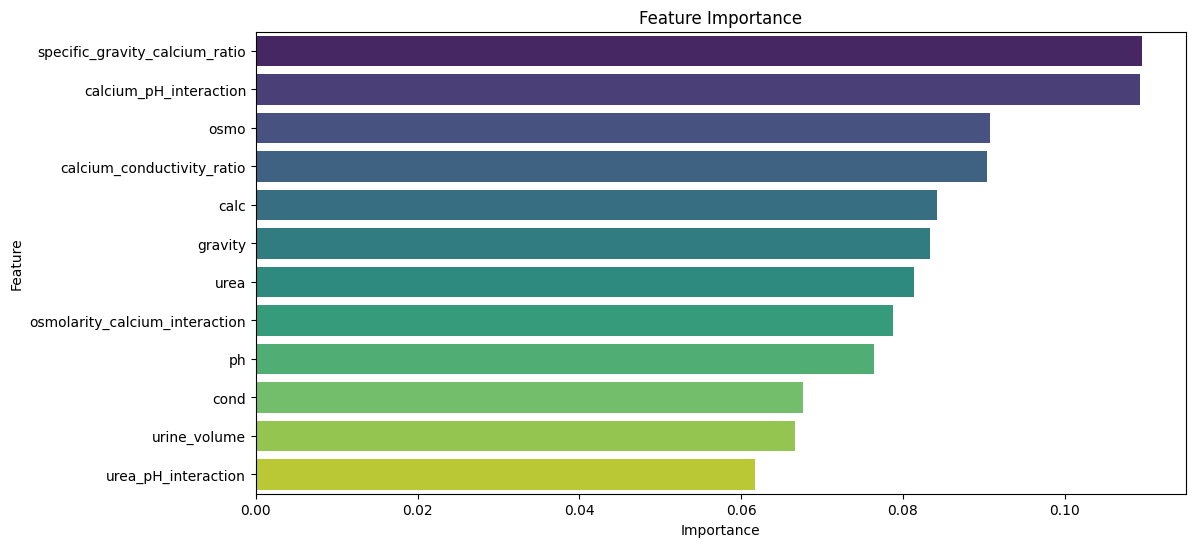

In [22]:
feature_importance = final_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Model Evaluation